# DopplerDriftSearch

The code we developed in the previous notebooks has been packaged into its own
Julia package named `DopplerDriftSearch.jl`.  To facilitate more general use it
has been slightly modified from the code presented earlier, but it largely
follows the same general design.  At the time this notebook was developed the
`DopplerDriftSearch.jl` package was not yet registered with the general Julia
project registry, so it needs to be added via a GitHub URL rather than by name.
This notebook shows how to do that, recreates some of the previous results
seen in earlier notebooks, and showcases some new functionality provided by the
`DopplerDriftSearch.jl` package.

## A brief(?) intro to Julia's package manager

Julia has a top notch package manager out of the box.  If you have had bad
experiences with package managers from other languages then you will be
pleasantly surprised by how good Julia's package manager is.  If you haven't had
bad experiences with package managers from other languages then you lead a
charmed life and may not realize how good Julia's package manager is.

When `julia` starts running, it has a default *project* that can be given by a
command line option (`--project`), an environment variable (`JULIA_PROJECT`),
or the user's default project (under `$HOME/.julia`).  This project file
specifies the other Julia packages that the project uses (i.e. *depends on*).
The project file can also include version compatibility constraints for each of
the other packages that the project depends on.  Julia packages are versioned
using *semantic versioning* and there is a flexible syntax for specifying ranges
of versions with which the project is compatible.  For more details, see the
Pkg.jl documentation.

### Resolving and instantiating

Before using any of the dependencies specified in `Project.toml`, the
dependencies must be *resolved* and *instantiated*.  Resolving the dependencies
means recursively retrieving the dependencies' `Project.toml` files and then
solving for the most recent version of every required package that satisfies all
of the version compatibility constraints specified across all packages.
In practice such a solution usually exists, but in the rare situation that a
solution cannot be found there are ways to "roll back" some packages to
earlier-but-still-compatible versions that will then allow for a solution to be
found, which can be a somewhat tedious process for fortunately it is rare.  Once
a solution is found it is written to a `Manifest.toml` file that lives alongside
`Project.toml`.  The specific versions of all the packages listed in
`Manifest.toml` will be used when packages are referenced in `using` or `import`
statements, but before they can be used they must be downloaded.  The
downloading of package versions listed in `Manifest.toml` is referred to as
`instantiating`.  After instantiation, mutually compatible versions of all the
dependencies will be used.

### Reproducibility vs flexibility

The ability for different groups to produce the same results is crucial for
scientific credibility and progress.  Taken together, the `Project.toml` and
`Manifest.toml` files guarantee that exactly the same environment can be
instantiated elsewhere, maximizing reproducibility.  For data analysis
applications, such as may be associated with scientific publications, both the
`Project.toml` and `Manifest.toml` files are usually managed in a version
control system (e.g `git`).  The complete package and version specificity of the
`Manifest.toml` file is ideally suited to this purpose.  On the other hand, for
packages that are more general purpose in nature, such strict version
constraints are not necessary and often make using a package more difficult.
For this reason, general purpose packages usually place just the `Project.toml`
file into the version control system and leave `Manifest.toml` to be locally
managed outside of version control. 

These notebooks are not a package that will be used by other packages or
applications, so in theory a `Manifest.toml` file could be placed into version
control along side the associated `Project.toml` file.  This would freeze the
versions of all dependency packages.  That would be good for reproducibility,
but it also prevents users of the notebooks from benefitting from new and
improved versions of various dependencies.  For that latter reason, the
`Manifest.toml` file is not included in the source control repository containing
these notebooks.  This means that the dependencies must be resolved and
instantiated before to notebooks can be used.  That's the purpose of the initial
Julia code block near the beginning of each notebook.

### Why explain this now?

The package registry is where the package manager retrieves metadata about all
the packagesi, including version compatibility constraints and the location of
the packages' files.  At the time of writing this notebook, the
`DopplerDriftSearch` package has not been registered with the general Julia
package repository on the Internet, but it is available from a public GitHub
repository.  It is possible to `add` a package from a GitHub (or other) URL,
which will add the name of the package to `Project.toml` and the URL to
`Manifest.toml`.  Since these notebooks do not include `Manifest.toml`, the
`DopplerDriftSearch` package must be (re-)added to `Project.toml` and
`Manifest.toml` before attempting to instantiate the project.

So without any further ado, we now perform the preliminary Julia setup that
includes the `DopplerDriftSearch` package!

In [6]:
# Perform some preliminary Julia setup 
# This may take some time the very first time it runs
using Pkg
Pkg.activate(@__DIR__)
Pkg.add(url="https://github.com/david-macmahon/DopplerDriftSearch.jl.git")
Pkg.instantiate()

using Plots
using CUDA
using FFTW
using HDF5
using Downloads
using LinearAlgebra
using BenchmarkTools
using DopplerDriftSearch

# Turn off legends in plots by default
default(legend=false)
# Disable scalar indexing to prevent use of inefficient access patterns
CUDA.allowscalar(false)

  Activating project at `~/JuliaDeDopplerNotebooks`


    Updating git-repo `https://github.com/david-macmahon/DopplerDriftSearch.jl.git`


   Resolving package versions...


  No Changes to `~/JuliaDeDopplerNotebooks/Project.toml`
  No Changes to `~/JuliaDeDopplerNotebooks/Manifest.toml`


## Read in the data

We're getting good at this...

In [7]:
voyager_url = "http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5"
h5 = h5open(Downloads.download(voyager_url))
full_spectrogram = h5["data"][:,1,:]
freq_range = range(659935, length=150)
spectrogram = full_spectrogram[freq_range,:]
size(spectrogram), size(full_spectrogram)

((150, 16), (1048576, 16))

## Use `intfdr` and `fftfdr` from DopplerDriftSearch

The DopplerDriftSearch package that we are using provides `intfdr` and `fftfdr`
so we can just use them out of the box!

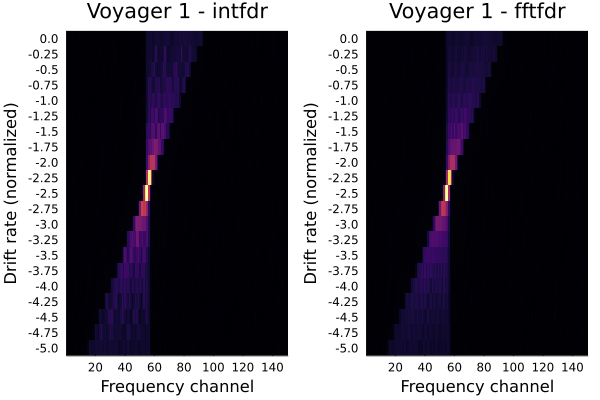

In [8]:
rates = 0:-0.25:-5
Nr = length(rates)
spectrogram_intfdr = intfdr(spectrogram, rates)
spectrogram_fftfdr = fftfdr(spectrogram, rates)
plot(
    heatmap(spectrogram_intfdr',
        title = "Voyager 1 - intfdr",
        xlabel = "Frequency channel",
        ylabel = "Drift rate (normalized)",
        yflip=true, yticks=(1:Nr, rates)
    ),
    heatmap(spectrogram_fftfdr',
        title = "Voyager 1 - fftfdr",
        xlabel = "Frequency channel",
        ylabel = "Drift rate (normalized)",
        yflip=true, yticks=(1:Nr, rates)
    ),
    layout=(1,2)
)

Yay, they look the same as before!

## Also works on a GPU

Let's use the GPU to recreate the FDR of a zoomed range of frequencies and drift rates.

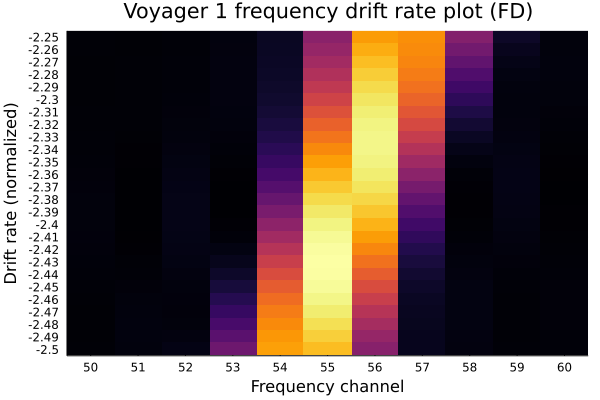

In [9]:
rates_zoom = -2.25:-0.01:-2.5
Nrz = length(rates_zoom)
cu_spectrogram = CuArray(spectrogram)
cu_fdr_zoom = fftfdr(cu_spectrogram, rates_zoom)
# Copy FDR back from GPU
fdr_zoom = Array(cu_fdr_zoom)
heatmap(50:60, 1:Nrz, fdr_zoom[50:60, :]',
    title="Voyager 1 frequency drift rate plot (FD)",
    xlabel="Frequency channel",
    ylabel="Drift rate (normalized)",
    xticks=50:60,
    yticks=(1:Nrz, rates_zoom),
    yflip=true
)

## New functionality for Fourier shifted spectrogram

In previous notebooks, we defined a function named `fdshift` that did the
following steps:

1. FFT'd a spectrogram along the frequency axis
2. Multiplied the Fourier domain data by delay rate phasors
3. Summed Fourier domain data long the time axis to a `Vector`
4. Backwards FFT'd the data to an FDR Vector for the given drift rate.

This functionality exists in DopplerDriftSearch, but it is called `fdshiftsum`
to reflect the fact that it returns a summed (i.e. integrated result).
DopplerDriftSearch provides a `fdshift` function that omits the sum step and
returns another spectrogram that has been shifted by the given drift rate.  We
can use this new functionality to produce Fourier domain shifted spectrograms.
The `intshift` function can be used to produce shifted spectrograms using only
integer shifts.  Let's compare the output of these two functions for a drift
rate of -2.34:

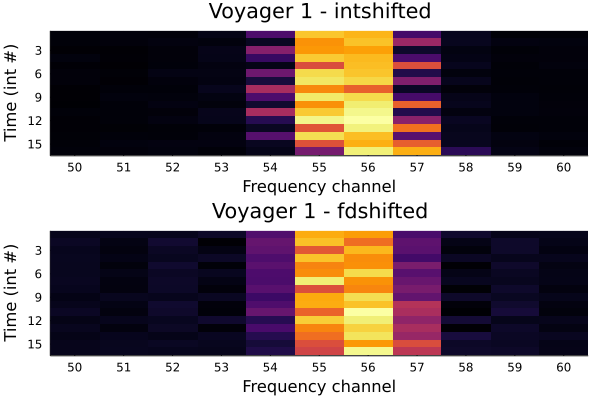

In [10]:
Nt = size(spectrogram, 2)
rate = -2.36
intshifted = intshift(spectrogram, rate)
fdshifted  = fdshift(spectrogram, rate)
plot(
    heatmap(50:60, 1:Nt, intshifted[50:60, :]',
        title = "Voyager 1 - intshifted",
        xlabel = "Frequency channel",
        ylabel = "Time (int #)",
        xticks=50:60, yflip=true
    ),
    heatmap(50:60, 1:Nt, fdshifted[50:60, :]',
        title = "Voyager 1 - fdshifted",
        xlabel = "Frequency channel",
        ylabel = "Time (int #)",
        xticks=50:60, yflip=true
    ),
    layout=(2,1)
)

The DopplerDriftSearch package has some great functionality already and more is on the way:

- Additional FDR generation techniques
- Hit detection (aka peak detection)

Stay tuned! 🚀